<a href="https://colab.research.google.com/github/SooMiiii/24-1-ESAA/blob/main/0329_%EC%BA%90%EA%B8%80_%EB%B9%84%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

---

# Customers clustering: K-Means, DBSCAN and AP

## 1. Introduction

K-Means, DBSCAN and Affinity Propagation 에 중점을 둔다.

## 2. Reading data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.5.3
numpy version: 1.25.2
seaborn version: 0.13.1


In [3]:
mall_data = pd.read_csv('Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [4]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
35,36,Female,21,33,81
111,112,Female,19,63,54
108,109,Male,68,63,43
192,193,Male,33,113,8
77,78,Male,40,54,48
60,61,Male,70,46,56
70,71,Male,70,49,55
144,145,Male,25,77,12
166,167,Male,42,86,20
73,74,Female,60,50,56


In [5]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


- 5개의 column이 있다.
- Gender 라는 범주형 column이 있다.
- 원-핫 인코딩을 할 수도 있지만 권장되지 않는다.

In [6]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

- 결측치가 없다.
- 하지만 실제 상황에서는 거의 발생하지 않는다.

## 3. Exploratory Data Analysis

### 3.1 Distributions

- 수치 변수를 자세히 조사할 것이다.
- 유일한 범주형 변수인 성별을 기준으로 계층화 된다.

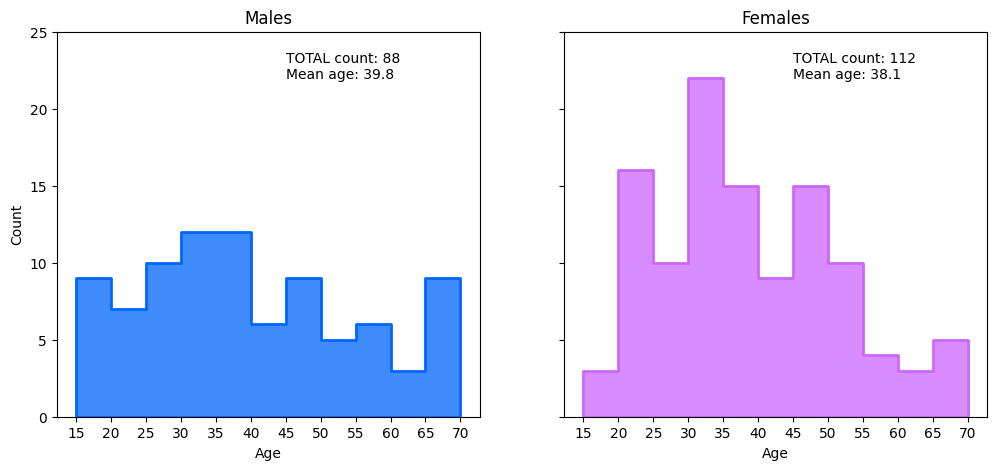

In [8]:
males_age = mall_data[mall_data['Gender'] == 'Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender'] == 'Female']['Age'] # subset with females age

age_bins = range(15, 75, 5)

# males histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.histplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=age_bins, ylim=(0, 25), title='Males', ylabel='Count')
axes[0].text(45, 23, f"TOTAL count: {males_age.count()}")
axes[0].text(45, 22, f"Mean age: {males_age.mean():.1f}")

# females histogram
sns.histplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=age_bins, title='Females', ylabel='Count')
axes[1].text(45, 23, f"TOTAL count: {females_age.count()}")
axes[1].text(45, 22, f"Mean age: {females_age.mean():.1f}")

plt.show()

In [9]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


- 남성 고객의 평균 연령은 여성 고객의 평균 연령에 비해 살짝 높다.
- 남성 연령 분포는 여성보다 균일하며 가장 큰 연령층은 30~35세이다.
- Kolgomorov-Smirnov test는 이 두 그룹 간의 차이가 통계적으로 유의하지 않음을 보여준다.

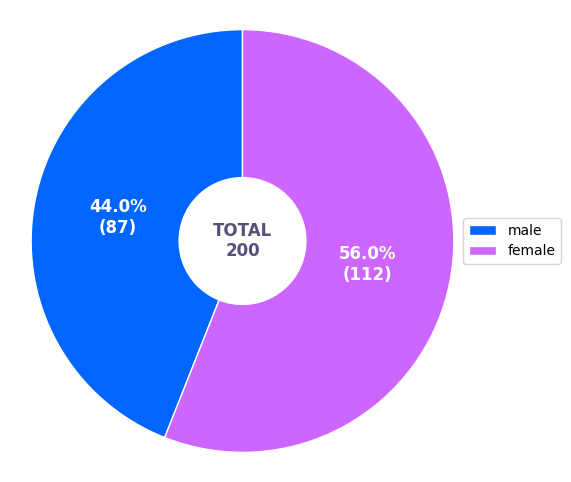

In [10]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

- 남성 고객보다 여성 고객이 약간 더 많다.

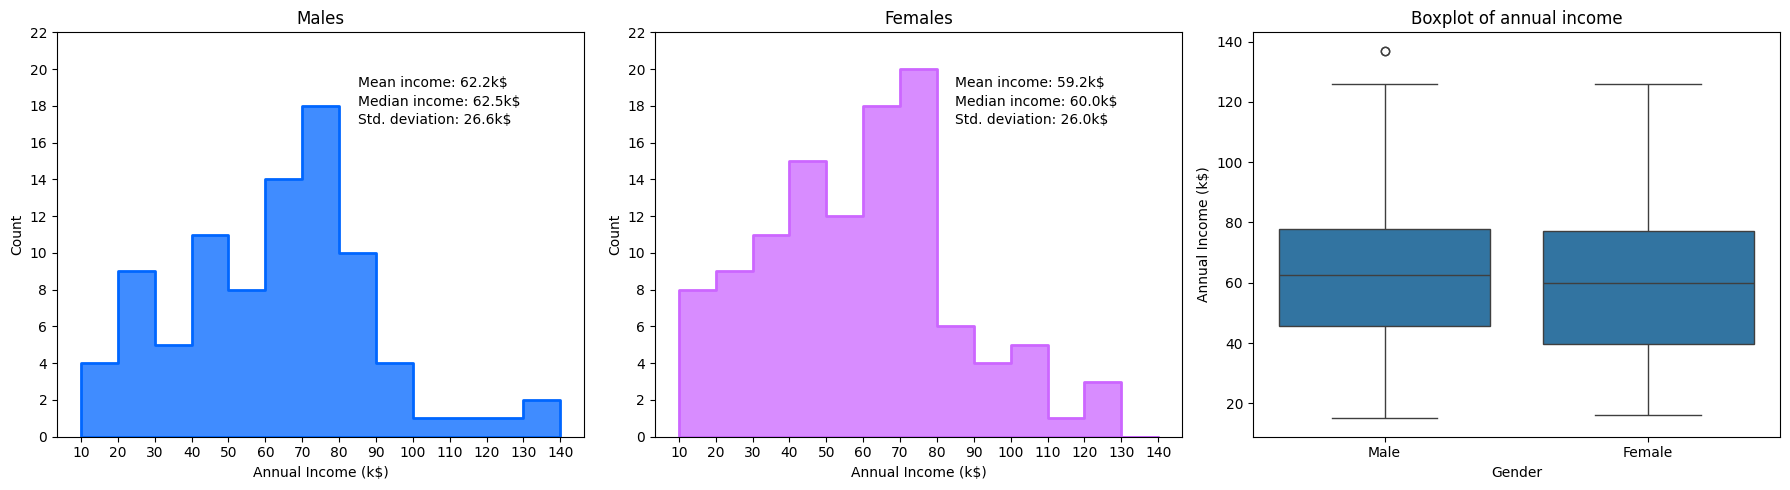

In [11]:
males_income = mall_data[mall_data['Gender'] == 'Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender'] == 'Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10, 150, 10)

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# males histogram
sns.histplot(data=males_income, bins=my_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=my_bins, yticks=range(0, 24, 2), ylim=(0, 22), title='Males', ylabel='Count')
axes[0].text(85, 19, f"Mean income: {males_income.mean():.1f}k$")
axes[0].text(85, 18, f"Median income: {males_income.median():.1f}k$")
axes[0].text(85, 17, f"Std. deviation: {males_income.std():.1f}k$")

# females histogram
sns.histplot(data=females_income, bins=my_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=my_bins, yticks=range(0, 24, 2), ylim=(0, 22), title='Females', ylabel='Count')
axes[1].text(85, 19, f"Mean income: {females_income.mean():.1f}k$")
axes[1].text(85, 18, f"Median income: {females_income.median():.1f}k$")
axes[1].text(85, 17, f"Std. deviation: {females_income.std():.1f}k$")

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=axes[2])
axes[2].set_title('Boxplot of annual income')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [12]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


- 남성의 평균 소득은 여성보다 높다. 표준편차는 두 그룹 모두 유사하다.
- 남성 그룹에는 특이치가 하나 있다.
- K-S 테스트에서는 두 그룹이 통계적으로 다르지 않은 것으로 나타났다.

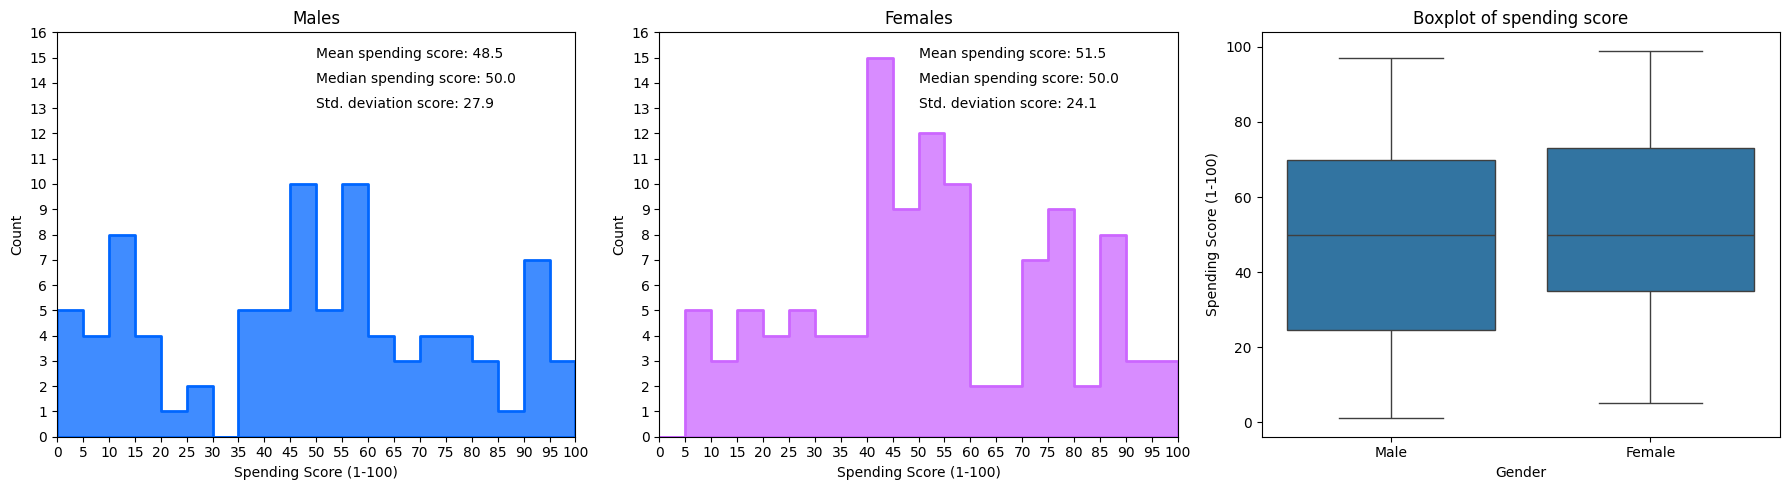

In [13]:
males_spending = mall_data[mall_data['Gender'] == 'Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender'] == 'Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0, 105, 5)

# create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# males histogram
sns.histplot(data=males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=spending_bins, xlim=(0, 100), yticks=range(0, 17, 1), ylim=(0, 16), title='Males', ylabel='Count')
axes[0].text(50, 15, f"Mean spending score: {males_spending.mean():.1f}")
axes[0].text(50, 14, f"Median spending score: {males_spending.median():.1f}")
axes[0].text(50, 13, f"Std. deviation score: {males_spending.std():.1f}")

# females histogram
sns.histplot(data=females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=spending_bins, xlim=(0, 100), yticks=range(0, 17, 1), ylim=(0, 16), title='Females', ylabel='Count')
axes[1].text(50, 15, f"Mean spending score: {females_spending.mean():.1f}")
axes[1].text(50, 14, f"Median spending score: {females_spending.median():.1f}")
axes[1].text(50, 13, f"Std. deviation score: {females_spending.std():.1f}")

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=axes[2])
axes[2].set_title('Boxplot of spending score')

# adjust spacing between subplots
plt.tight_layout()
plt.show()

In [14]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


- 여성의 평균 지출 점수가 남성보다 높다.
- K-S 검정 p-값은 귀무가설을 기각할 증거가 없음을 나타낸다.
- 그러나 증거는 이전 비교만큼 강력하지 않다.

In [15]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

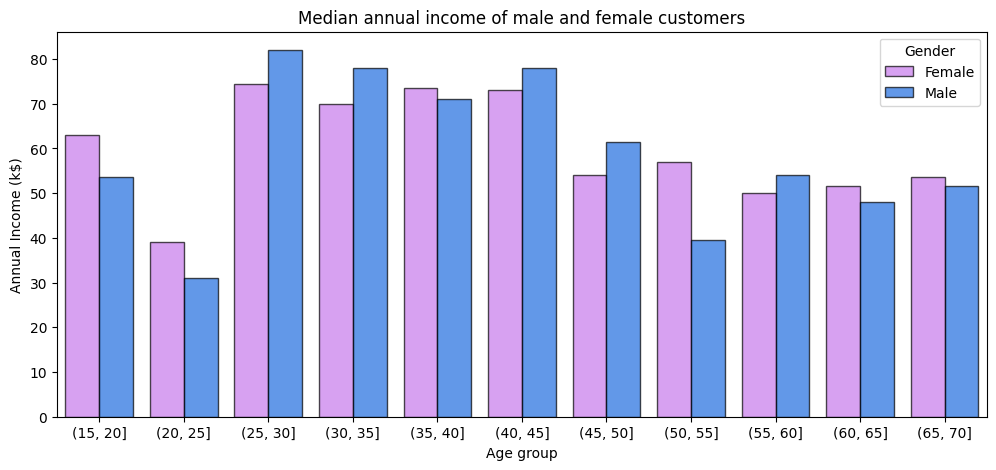

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

- 가장 부유한 고객이 25~45세임을 보여준다.
- 여성과 남성의 가장 큰 차이는 25~30세와 50~55세 연령대에서 나타난다.

### 3.2 Correlations

- 수치 변수 간의 상관관계 조사

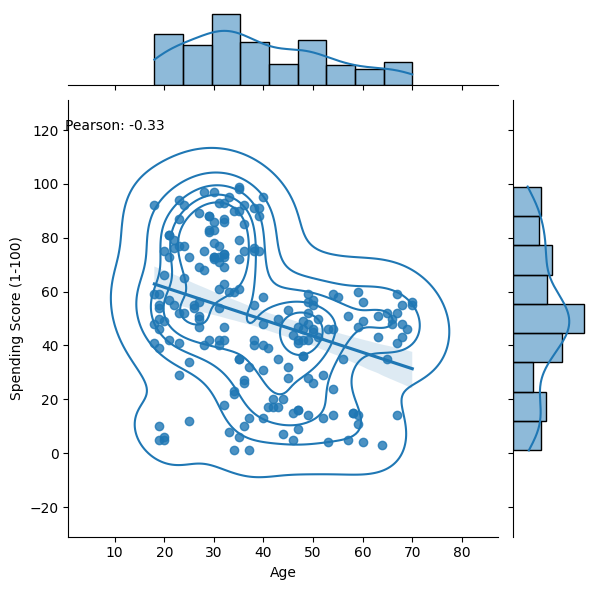

In [17]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(x='Age', y='Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

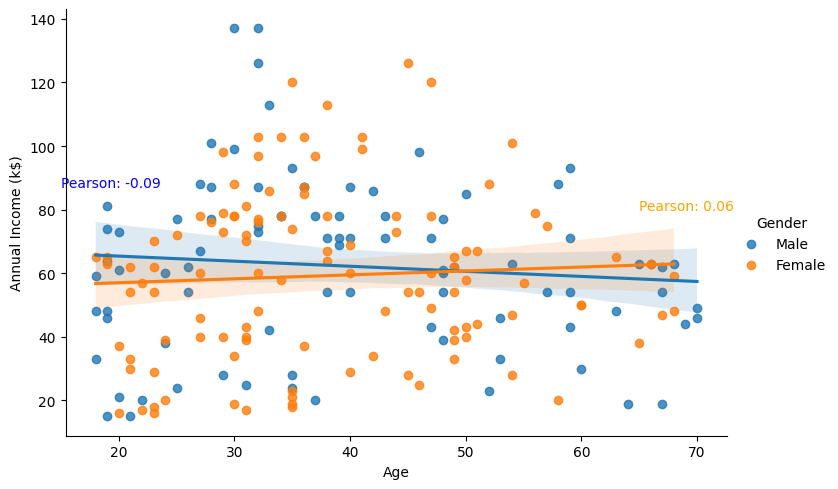

In [18]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='Age', y='Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

- 성별에 관계없이 고객의 연령과 연간 소득 사이에는 무시할 만한 상관관계가 있다.

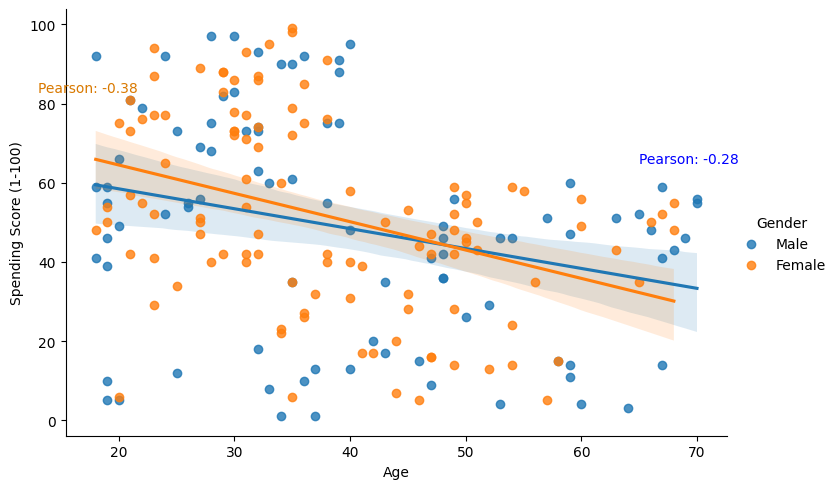

In [19]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

- 두 성별 모두 연령과 지출 점수 사이에는 주간 음의 상관관계(<0.5)가 있다.

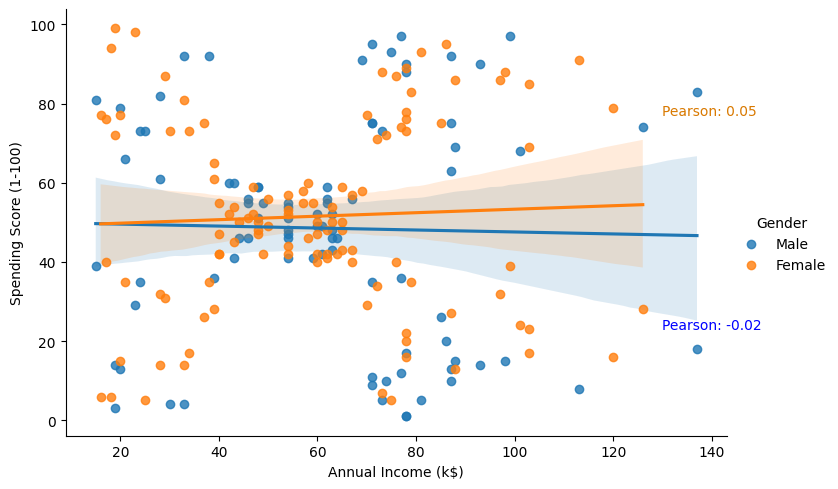

In [20]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)


sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender',
           aspect=1.5)


plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

- 성별에 관계없이 고객의 연간 소득과 지출 점수 사이에는 무시할 만한 상관관계가 있다.

## 4. Clustering

- K-Means, DBSCAN, Affinity Propagation
- 여기서는 표준화하지 않겠다.

### 4.1 K-Means

- 이 장에서는 대부분의 기계 학습 과정에서 가르치는 매우 인기 있는 K-Means 알고리즘에 중점을 둔다.

#### 4.1.1 Description

3가지 주요 단계
1. 시드 포인트를 사용하여 샘플을 초기 그룹으로 분할 -> 이러한 시드 포인트에 가장 가까운 샘플은 초기 클러스터를 생성

2. 그룹의 중심점(중심)까지의 샘플 거리를 계산, 가장 가까운 샘플을 클러스터에 할당

3. 새로 생성된(업데이트된) 클러스터 중심을 계산

알고리즘이 수렴할 때까지 2단계와 3단계를 반복

K-Means의 목표: 모든 클러스터에 걸쳐 목적 함수(아래 사진)를 최소화하는 것

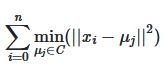

NP-hard problem : 지역 최솟값으로 수렴한다.
-  Lloyd’s K-Means algorithm 의 계산비용은 O(kn)
- k는 클러스터 수, n은 샘플 수
- 다른 클러스터링 알고리즘과 비교할 때 나쁘지 않다.
- 일반적으로 지역 최솟값으로 수렴함에도 불구하고 K-Means는 상대적으로 빠르며 그룹이 잘 분리되어 있으면 전역 최솟값으로 수렴할 가능성이 높다.
- 클러스터화의 결과는 초기화 기준에 따라 달라지기 때문에 다양한 초기화 지점에 대한 분석을 실행하고 선택해야 한다.
- 지역 최솟값 문제를 해결하는 알고리즘 일부 개선 -> Firefly 알고리즘 사용

K-Means의 세 가지 주요 매개변수

1. Initialisation criteria
- scikit-learn에서는 "k-means++"라는 영리한 초기화 방식이 구현
- 서로 멀리 떨어져 있는 초기 중심을 생성하여 더 나은 결과를 얻을 확률을 높인다.
- 작위 포인트 생성기를 사용할 수도

2. Number of clusters
- 클러스터를 선택하는 것이 가장 어렵다.
- 가장 대표적인 방식 : 엘보 방식, 실루엣 점수, 등등

3. 거리 측정법
- 점 사이의 거리 계산
 - 대표 : 유클리드 메트릭 -> 구형 K-Means

#### 4.1.2 Use case - customers segmentation

라이브러리 가져오기

In [21]:
from sklearn.cluster import KMeans

클러스터링에는 숫자 열만 사용 -> 성별은 사용 x

In [22]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

클러스터 개수를 찾기 위해 엘보 방법 사용
- 그래프에서 꼬임 또는 "팔꿈치"가 보이는 클러스터 수를 선택

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

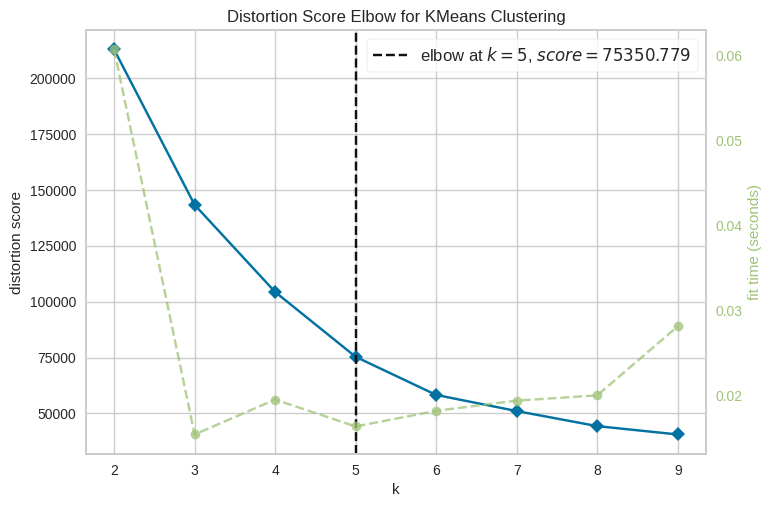

In [23]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- 그래프는 클러스터 수가 증가함에 따라 왜곡 점수가 감소함.
- 그러나 명확한 엘보는 보이지 않는다.
- 기본 알고리즘은 5개 클러스터 제안 -> 5개 또는 6개를 선택하는 것이 좋아 보인다.

실루엣 점수 확인

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

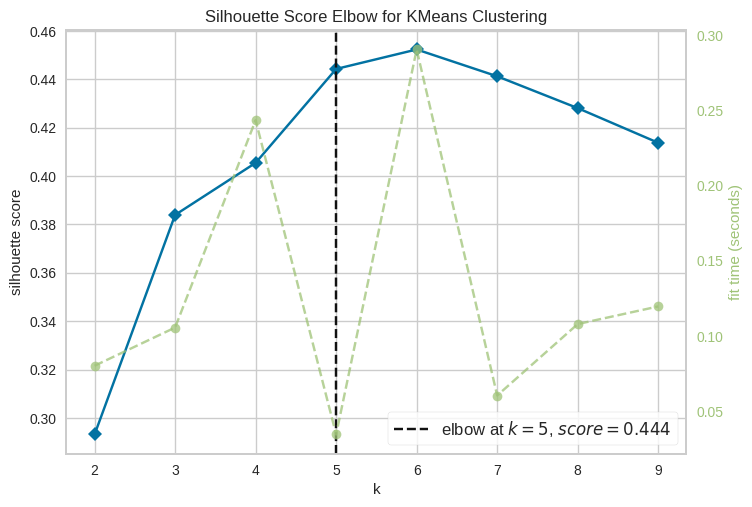

In [24]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- 실루엣 점수 결과 : 5개 또는 6개 -> 비교해보자

(1) 5개

In [25]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


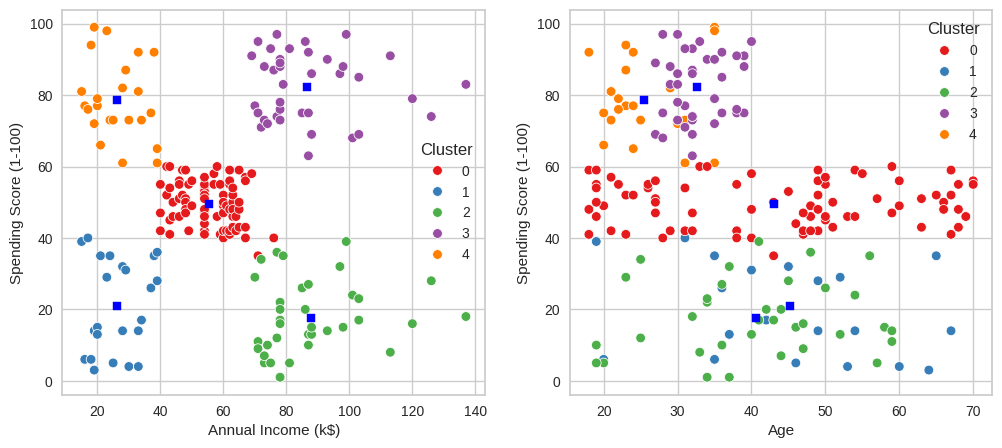

In [26]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

5개의 클러스터를 생성
- 연소득이 낮고 지출 점수가 높은 고객
- 중간 연소득과 중간 지출 점수를 가진 고객
- 연소득은 높고 지출 점수는 낮은 고객
- 연소득이 높고 지출 점수가 높은 고객
- 연소득이 낮고 지출 점수가 낮은 고객

고객 연령에 따라 별도의 그룹이 없다.

군집별 크기

In [27]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,79
1,23
2,36
3,39
4,23


- 가장 큰 클러스터 : 1번

3D 시각화

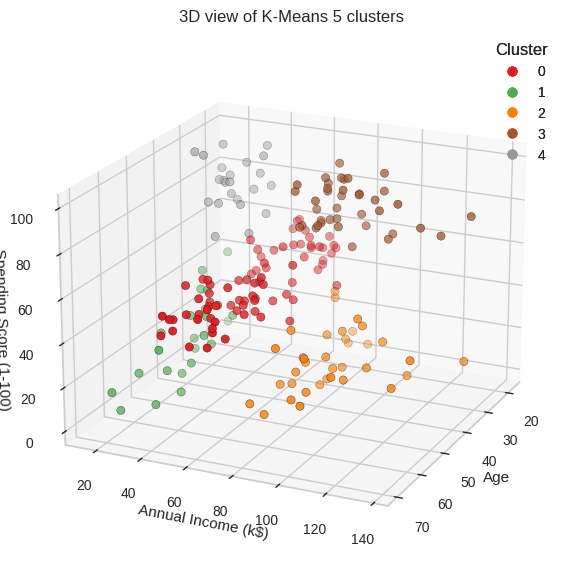

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d', elev=20, azim=210)
scatter = ax.scatter(KM5_clustered['Age'],
                     KM5_clustered['Annual Income (k$)'],
                     KM5_clustered['Spending Score (1-100)'],
                     c=KM5_clustered['Cluster'],
                     s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.azim = 25

# Create a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
ax.add_artist(legend)

plt.show()

In [29]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

각 클러스터의 품질을 확인하기 위해 실루엣 플롯 검사

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



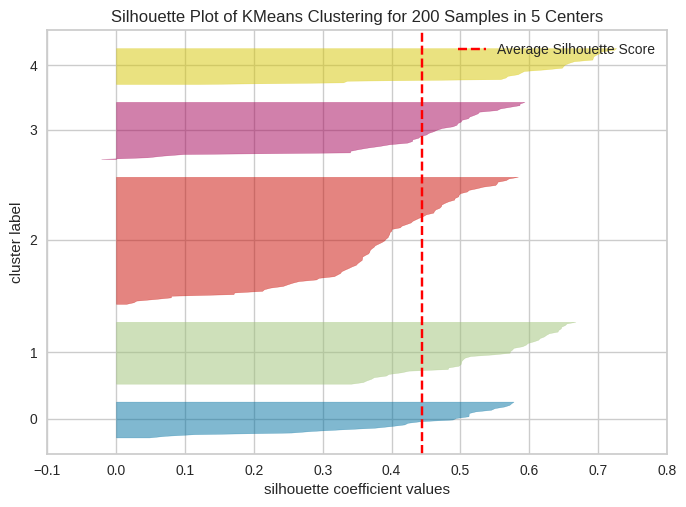

In [30]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

(2) 6개

In [31]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



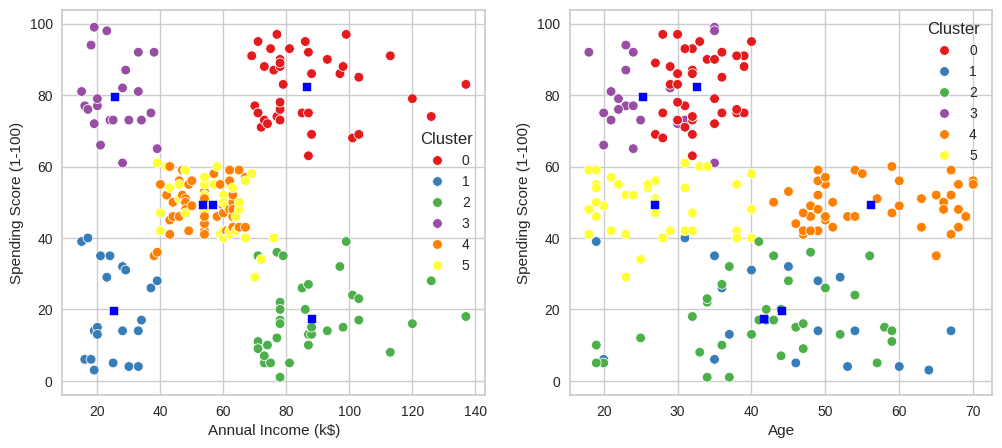

In [32]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

- 연간 **중간** 및 **중간** 지출 점수를 보유한 젊은 고객
- 연간 소득이 **높고** 지출 점수가 **낮음**인 고객
- 연간 **중간** 및 **중간** 지출 점수를 보유한 젊은 고객
- **높은** 연간 소득과 **높은** 지출 점수를 가진 고객
- 연간 소득이 **낮고** 지출 점수가 **낮은** 고객
- 연간 소득이 **낮고** 지출 점수가 **높은** 고객

고객 연령에 따른 별도의 그룹 x

In [33]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,39
1,21
2,35
3,22
4,45
5,38


In [34]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



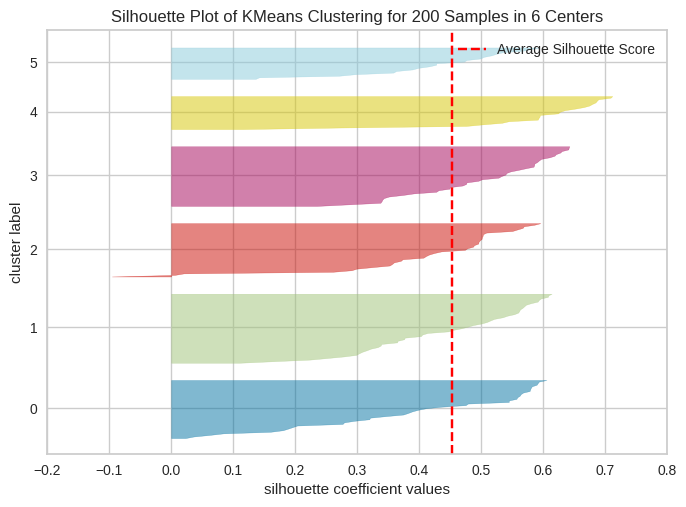

In [35]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

### 4.2 DBSCAN

#### 4.2.1 Description

Density-Based Spatial Clustering of Application with Noise의 약자

- 핵심 아이디어 : 밀집 지역 개념에 관한 것
- 자연 클러스터는 밀집된 지점으로 구성되어 있다고 가정
- "밀집 지역"의 정의가 필요 -> 두 매개변수가 필요
 - Eps, ε - 거리
 - MinPts – 거리 Eps 내의 최소 포인트 수
- 거리 측정법은 사용자가 지정할 수 있지만 일반적으로 유클리드 거리가 구현된다.

->
- "밀집 영역"은 모든 지점 사이의 거리 Eps 내에 있는 최소 개수의 지점으로 생성
- 이 거리 내에 있지만 다른 지점의 최소 수에 가깝지 않은 지점은 "경계 지점"
- 나머지는 노이즈 또는 이상치

(그림)
- 빨간색 : 밀집 지역
- 초록색 : 경계 지점
- 파란색 : 이상치

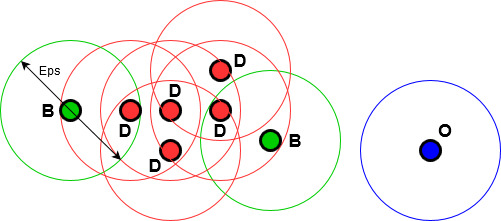

장점
- Eps 와 MinPts 매개변수를 기반으로 클러스터 자체의 수를 찾는다.
 - 길쭉한 클러스터 또는 다른 클러스터로 둘러싸인 클러스터를 구별할 수 있다.
 - K-Means는 항상 볼록하다.
- 어떤 클러스터에도 맞지 않는 점을 찾을 수 있고, 이상값을 감지할 수 있다.

단점
- 각 지점에 대해 이웃 쿼리를 실행해야 하기 때문에 평균 O(n log(n))의 높은 계산 비용이 발생
- 다양한 밀도의 클러스터를 제대로 식별하지 못함


#### 4.2.2 Use case - customers segmentation

In [36]:
from sklearn.cluster import DBSCAN

두 가지하이퍼파라미터가 있다.
- eps, min_samples

In [37]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

생성된 클러스터 수를 확인

In [38]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))


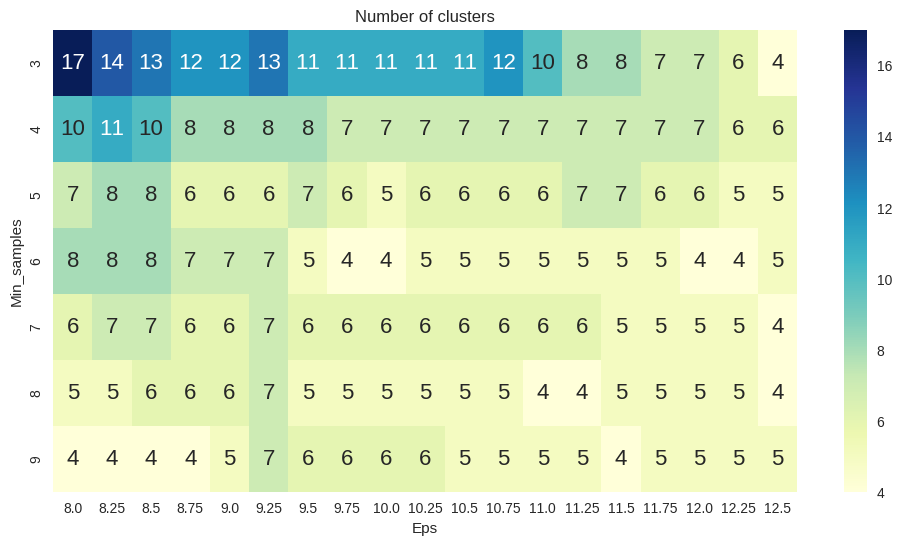

In [39]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

- 히트맵에서는 클러스터 수가 4~17까지 다양하다는 것을 보여준다. 그러나 대부분은 4~7개이다.

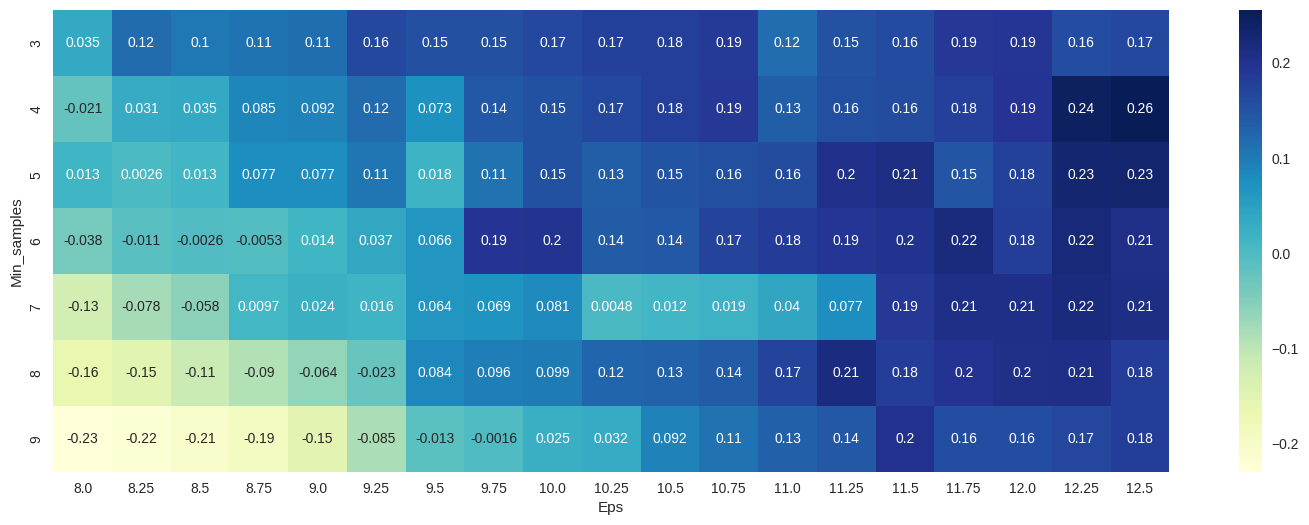

In [40]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

- EPS=12.5, min_samples=4 일 때 전역 최대값은 0.26

sizes of clusters

In [41]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [42]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


- 5개의 클러스터와 이상값 클러스터(-1)를 생성
- 일부 클러스터에는 관측치가 4개만 있다. 18개의 이상값도 있다.

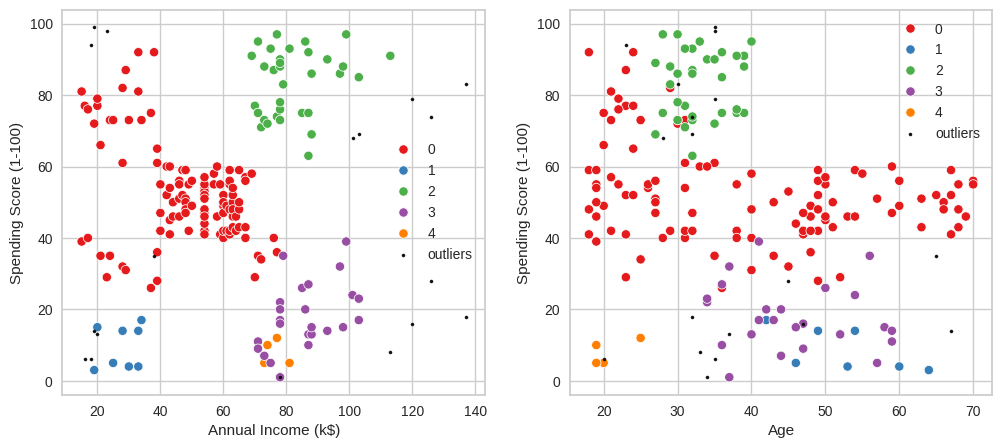

In [43]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

- 몇 가지 이상값이 있음을 보여준다.

### 4.3 Affinity Propagation

#### 4.3.1 Description

- 수렴될 때까지 한 쌍의 지점 간에 메시지를 보내는 개념을 기반으로 구축
- 최적의 클러스터 수를 자체적으로 찾는다.
- 가장 큰 장점 : 초기화 기준에 대한 민감도가 부족하다는 것

- 두 가지 매개변수 지정
  - 음수이며 사용되는 예시 수를 제어하는 기본 설정
  - 메시지 업데이트 시 수치 진동을 방지하는 감쇠 계수

#### 4.3.2 Use case - customers segmentation

In [44]:
from sklearn.cluster import AffinityPropagation

In [45]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))

af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


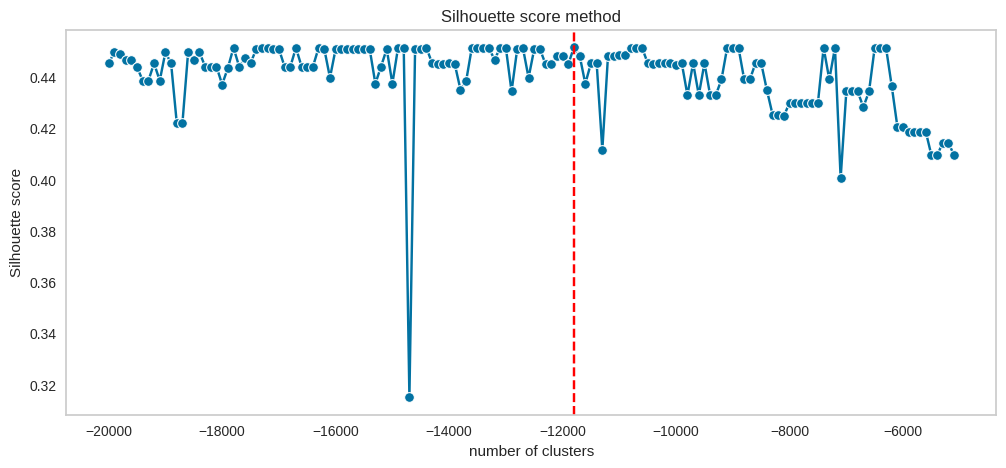

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=preferences, y=af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [47]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [48]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [49]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


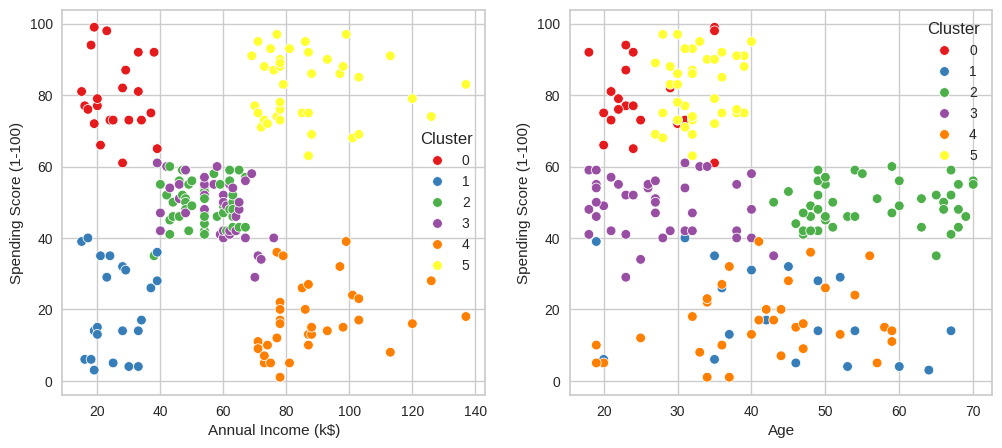

In [50]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))

scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

- K-Means의 결과와 비슷하게 나왔다.

## 5. Comparison and discussion

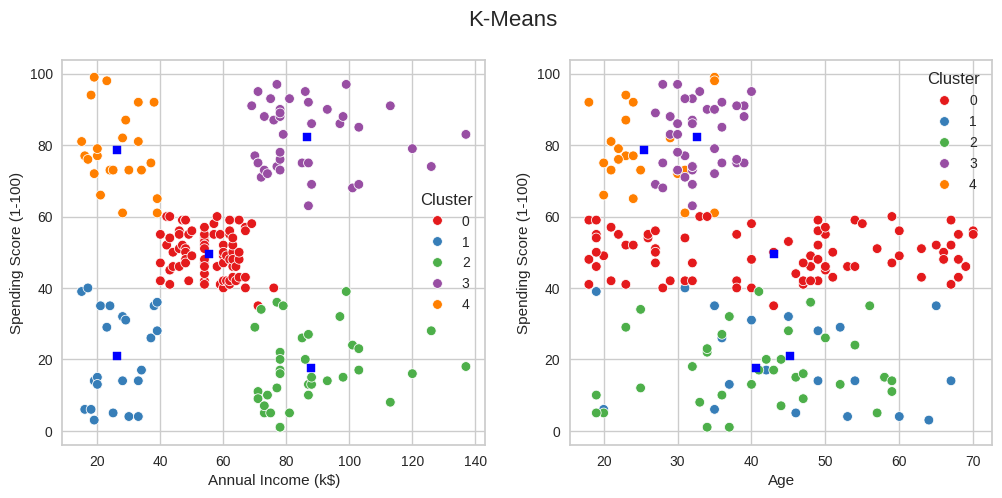

In [51]:
fig1.suptitle('K-Means', fontsize=16)
fig1

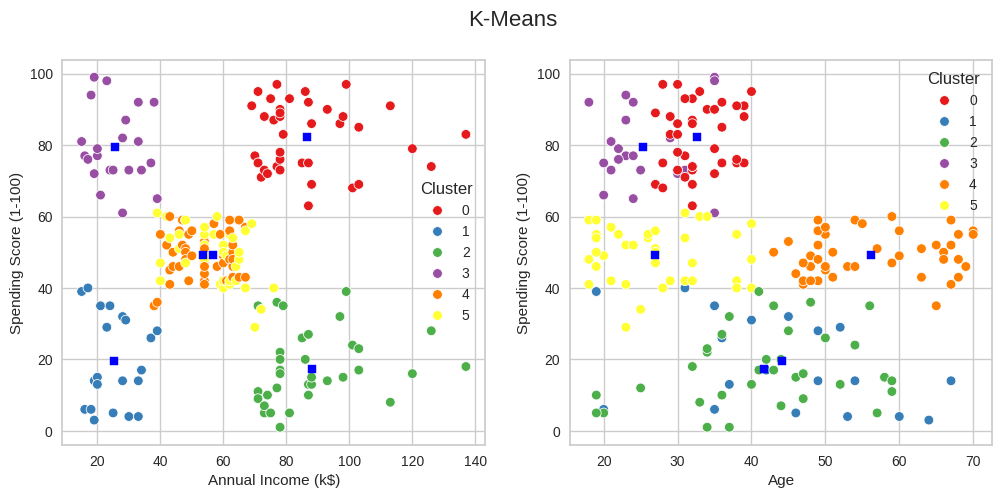

In [52]:
fig11.suptitle('K-Means', fontsize=16)
fig11

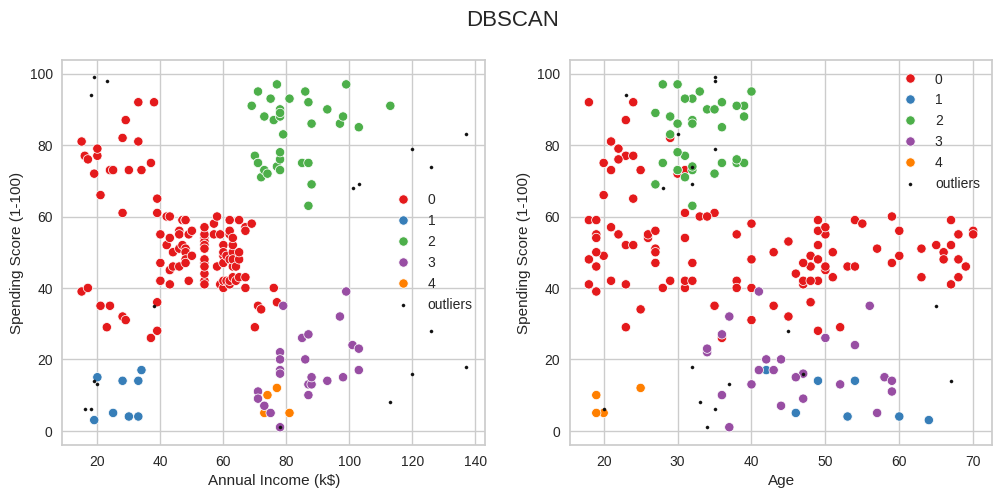

In [53]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

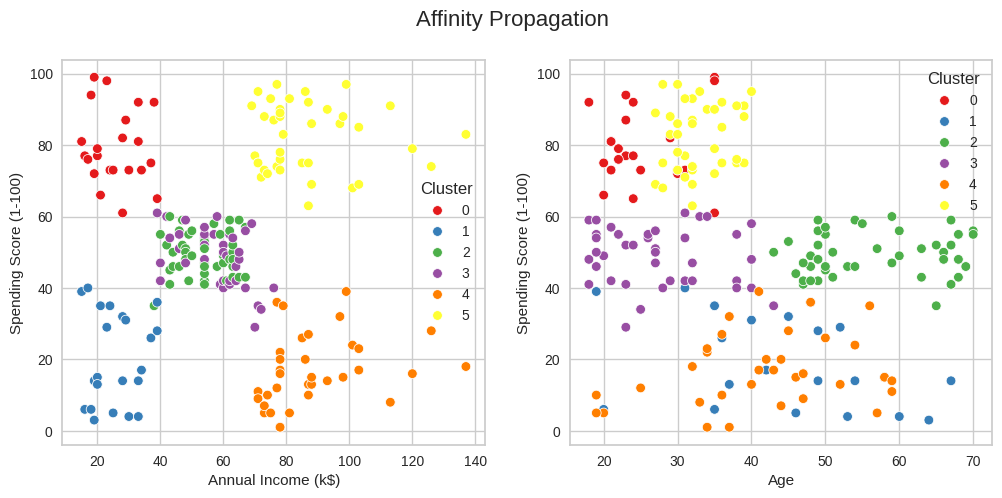

In [54]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

아래 표에는 생성된 클러스터의 크기가 나와있다.
- 번호 지정 밥법은 각 방법마다 다르다.
> K-Means의 클러스터 번호 0은 DBSCAN의 클러스터 번호 2 및 Affinity Propagation의 클러스터 번호 2와 동일

In [55]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,39.0,112.0,22.0
1,21.0,8.0,22.0
2,35.0,34.0,44.0
3,22.0,24.0,39.0
4,45.0,4.0,34.0
5,38.0,NaN,39.0
-1,NaN,18.0,NaN


- 위의 비교를 통해 DBSCAN이 합리적인 클러스터를 생성하지 못했다는 것이 분명해졌다.
 - 밀도 기반으로 찾으려 해서...

- 결과 : K-Means 와 Affinity Propagation 알고리즘은 합리적인 6개의 클러스터를 생성